# Predicting freight rates using regression methods

##### Created by Lucas Zarpellon

LinkedIn https://www.linkedin.com/in/lucasingleszarpellon/
<br>
E-mail lucasiz.zarpellon0@gmail.com
<br>
GitHub
https://github.com/lcszarpellon

#### Do you even wonder how Math and Machine Learning could help you save money in transportation for your logistics operation?  
If that's the case, I may have a solution for you!
We're going to apply some regression models to predict rates based on some factor that might influence the cost.

Usually, we see prediction being used in data that depends on a time, but today, we're going to deal with a dataset that's not time dependent.

First of all, let's plan how we are going to do this.
<br><br>
Here are the steps that we're going to follow:

    1.Import the necessary libraries 
    2.Read and clean the dataset (ETL)
    3.Exploratory Analysis
    4.Feature Engineering
    5.Normalizing test & Transformation
    6.Model Building  
    7.Conclusion


#### **1. Importing the necessary libraries**

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.svm import SVR
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import chi2 
sns.set_theme(rc={'figure.figsize':(12,8)})

#### **2. Read and clean the dataset (ETL)**

As always, in data projects, we're going to read and clean the data, firstly identifying how many Nulls we have, so we can later remove them.

In [19]:
freight_df = pd.read_excel(r'data/Freight_Rates.xlsx')
print(freight_df.dtypes)
null_cols = (freight_df.isnull().sum())
null_percent = (null_cols/len(freight_df))*100
print(f'\n{null_cols}')
print(f'\n{null_percent}')

transportation_mode     object
segment                 object
incoterms_key           object
quantity                 int64
distance               float64
distance_unit           object
shipment_cost          float64
lead_time_days           int64
currency                object
freight_rate           float64
dtype: object

transportation_mode    0
segment                0
incoterms_key          0
quantity               0
distance               0
distance_unit          0
shipment_cost          9
lead_time_days         0
currency               0
freight_rate           0
dtype: int64

transportation_mode    0.000000
segment                0.000000
incoterms_key          0.000000
quantity               0.000000
distance               0.000000
distance_unit          0.000000
shipment_cost          0.125418
lead_time_days         0.000000
currency               0.000000
freight_rate           0.000000
dtype: float64


The column that we're trying to predict is the *"freigh_rate"* and since we have 9 nulls in the shipment_cost column (that's numerical), we're replacing Nulls with the average. 

In [20]:
freight_df['shipment_cost'] = freight_df['shipment_cost'].fillna(freight_df['shipment_cost'].mean())
null_list = list(null_cols[null_cols!=0].index.values)
print(freight_df.isnull().sum())

transportation_mode    0
segment                0
incoterms_key          0
quantity               0
distance               0
distance_unit          0
shipment_cost          0
lead_time_days         0
currency               0
freight_rate           0
dtype: int64


Before moving to the Exploratory Analysis, we'll be separating the categorical Data and numerical data.

In [21]:
cat = freight_df.select_dtypes(exclude = [int,float])
num = freight_df.select_dtypes(exclude = ['object'])

#### **3. Exploratory Analysis**

The first thing we'll do in this part, is to explore the relation between categorial and freight rate, to see how **much does the categorical columns influences the freight rate**.

##### 3.1 Exploring the relation between Freight Rate and Categorical data 

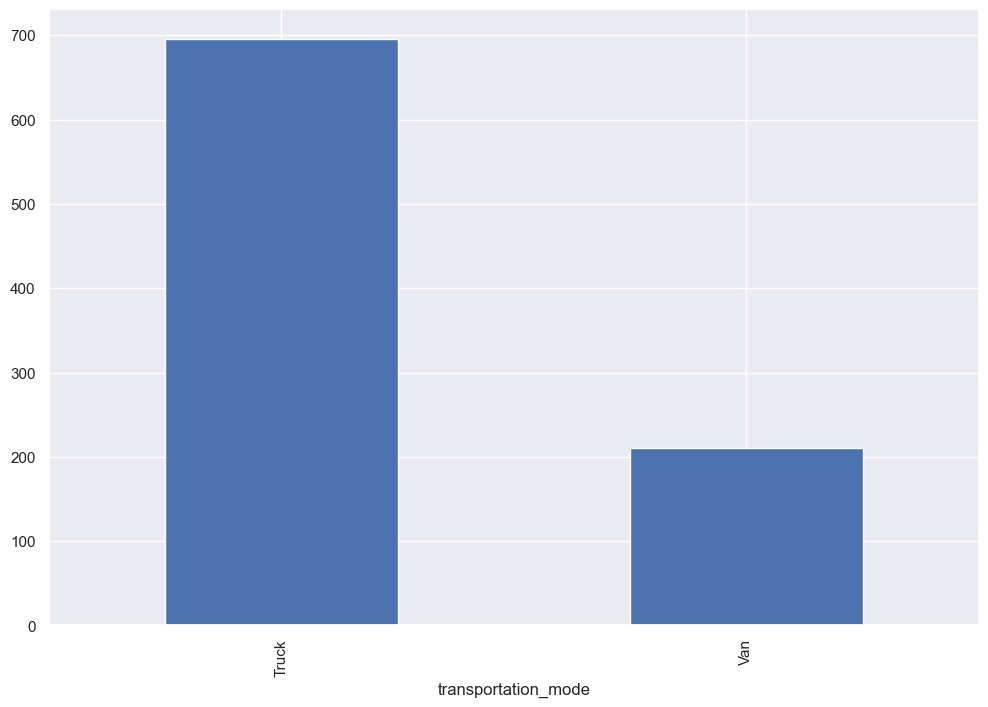

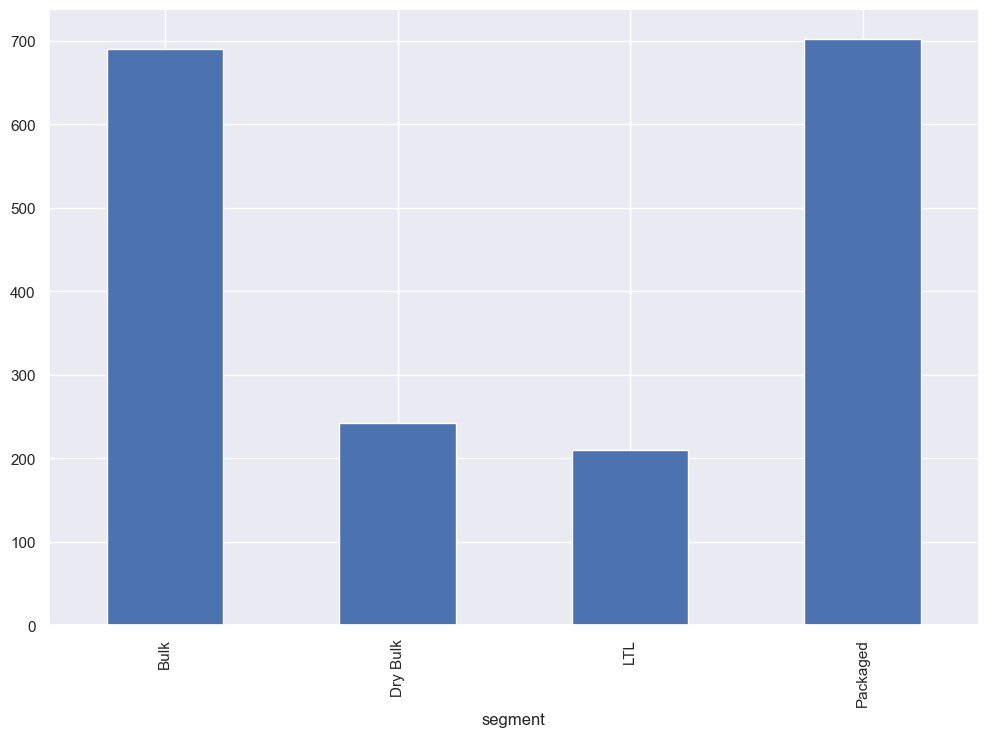

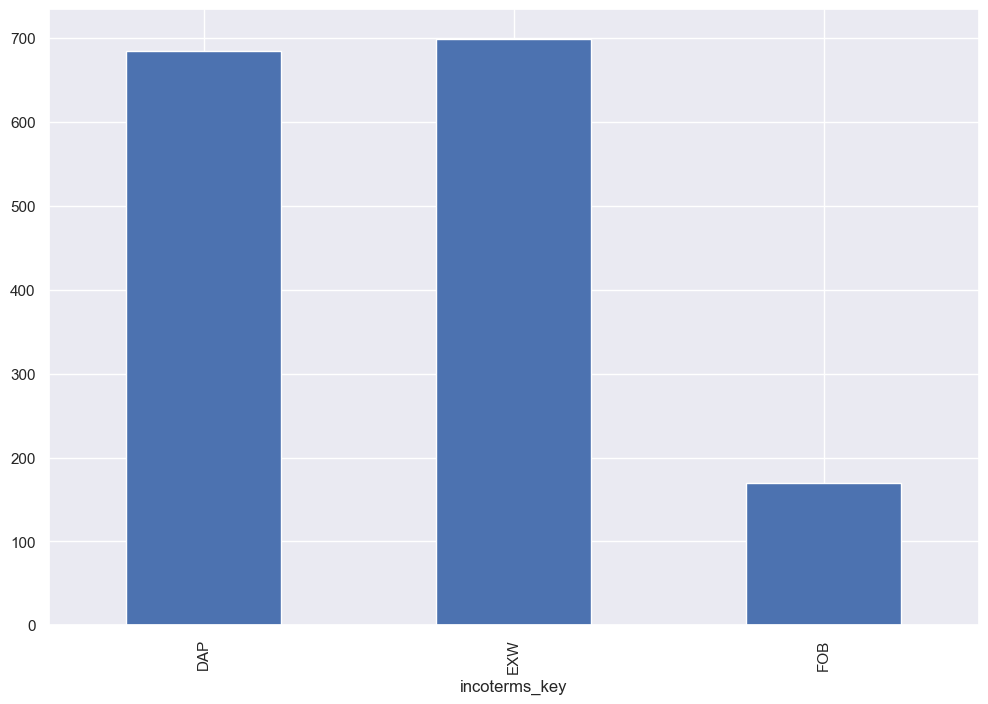

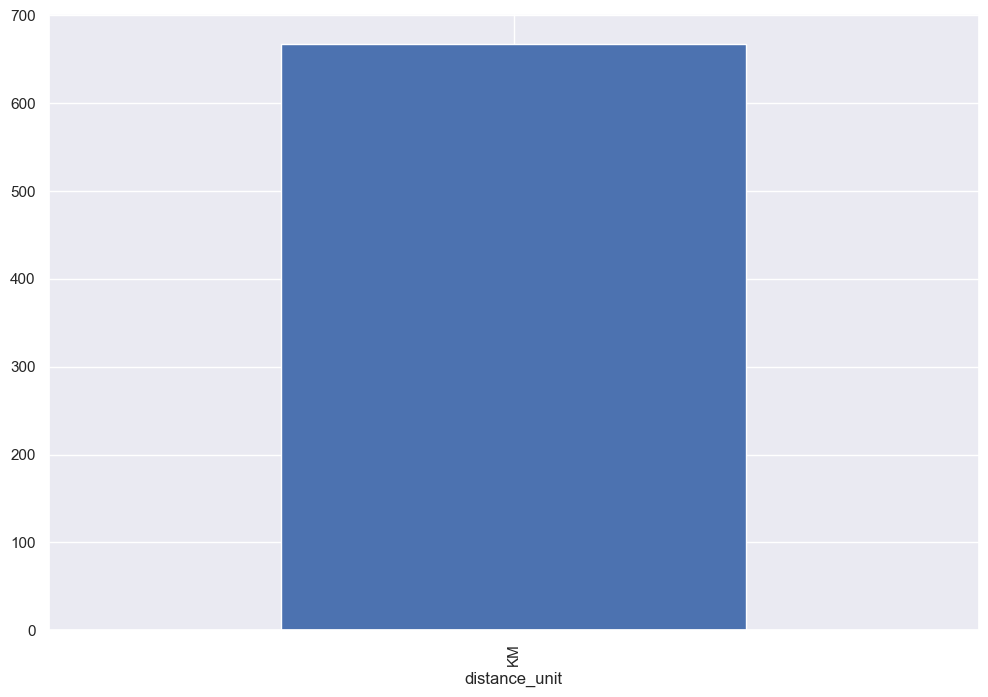

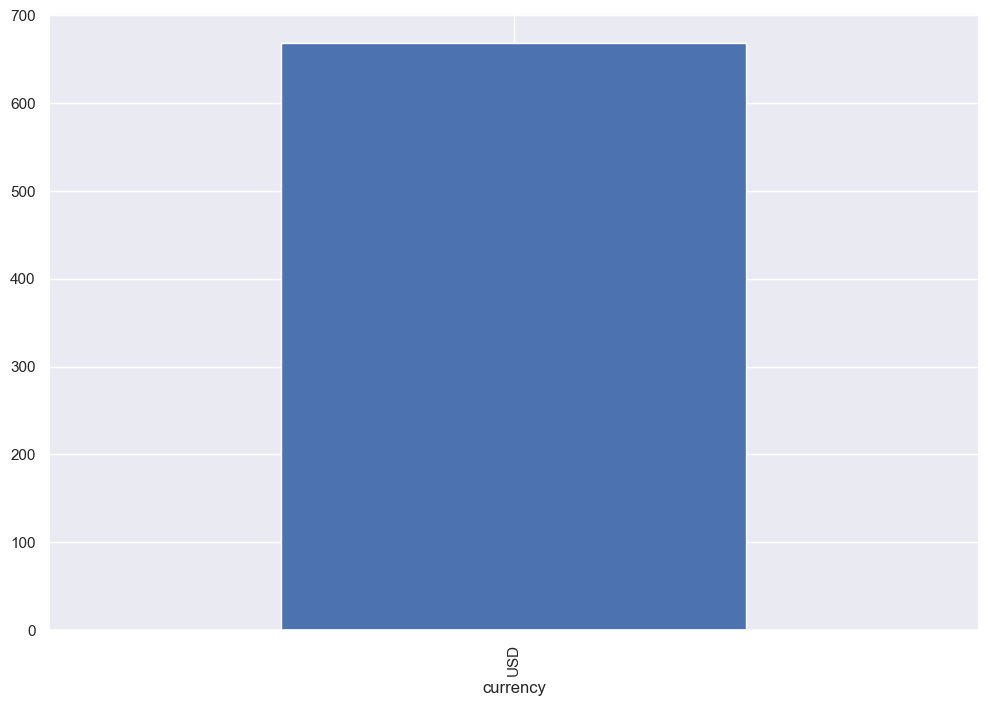

In [22]:
for k in cat:
    if k != 'freight_rate':
        mean_df = freight_df.groupby([k])['freight_rate'].mean() ## here I chose to group the categorical columns based on the mean fright rate, but it could also be done with the sum.
        mean_df.plot.bar()
        plt.show()

From this analysis we can draw some conclusions
<br><br>
I) distance_unit and currency are irrelevant (we can remove them);
<br>
II) Truck is more expensive than Van;
<br>
III) Transporting Bulk and dry package is also more expensive than the rest;
<br>
IV) Ex Works incoterm (EXW - exports) cost more to transport.

##### 3.2 Exploring the relation between Freight Rate and numerical data 

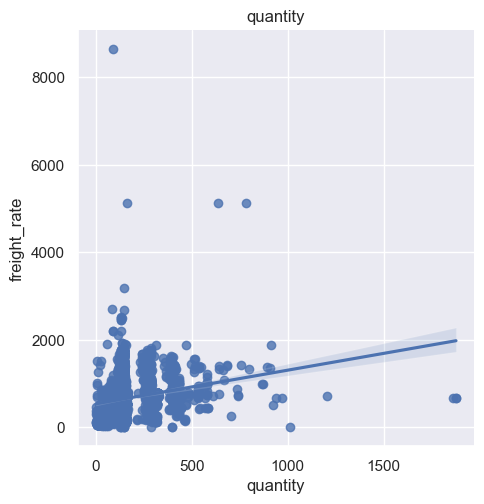

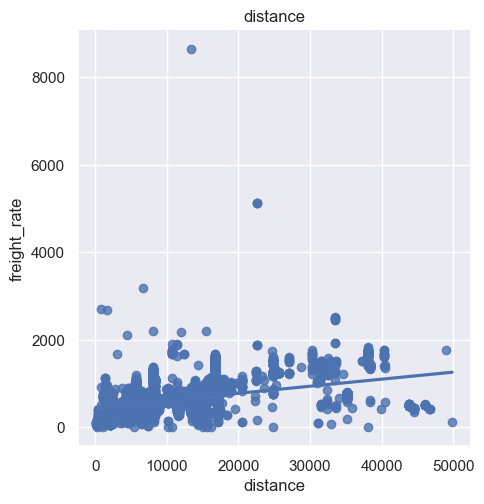

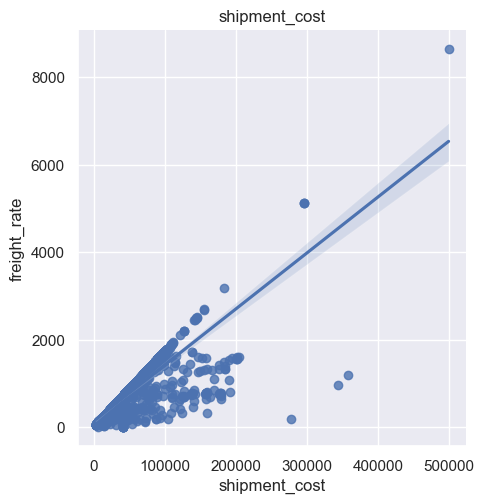

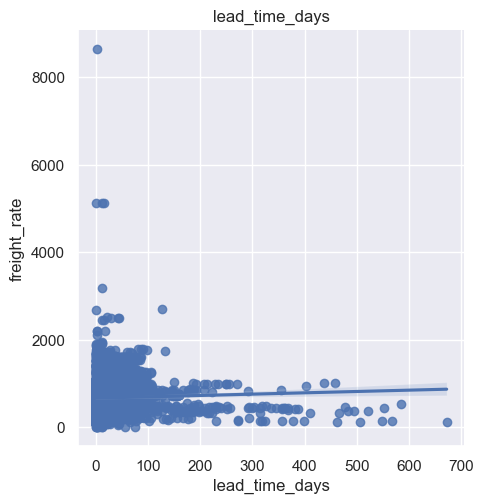

In [41]:
for k in num:
    if k != 'freight_rate': 
        sns.lmplot(x=k,y='freight_rate', data=num, order = 1)
        plt.title(k)
        plt.ylabel('freight_rate')
        plt.xlabel(k)
        plt.show()

The point that we can conclude from here are:
<br><br>
I) quantity is somewhat corelated linearly with distance, but that's because it probably involves changing the vehicle type;
<br>
II) Distance has a good linear relation with the rate, but we cannot state that this is a linear dependency;
<br>
III) shipment cost has an almost perfect liner dependency with freight rate, we may overfit the model if we consider this one, and it's not worth using it since most of the time, if we have the total shipment cost, we already have the freight rate;
<br>
IV) Lead time has a very weak relation with freight rate, it's a strong candidate to be removed.


##### 3.3 Exploring Distribution 

The next step is to check for normal distribution in the numerical data, that because most regressions assumes a gaussian distribution.

This analysis will help us understand if the data needs to be tranformed.

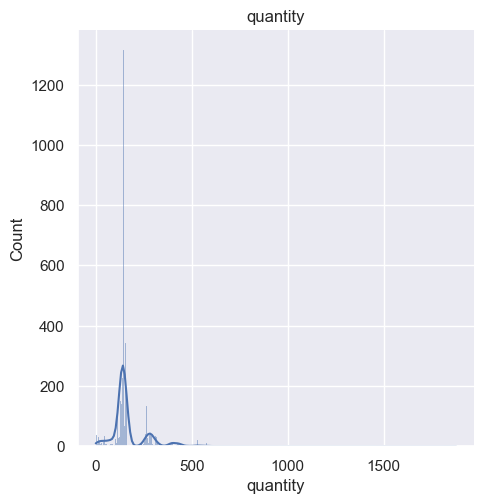

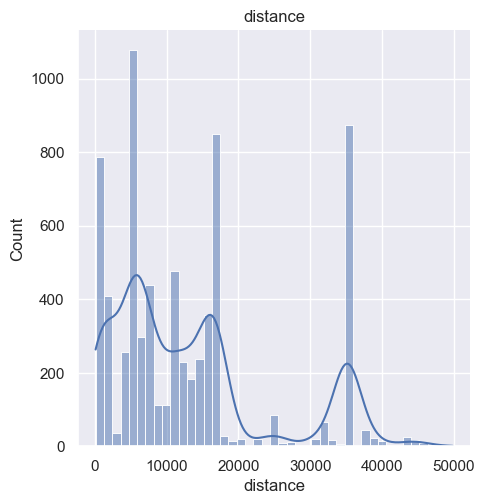

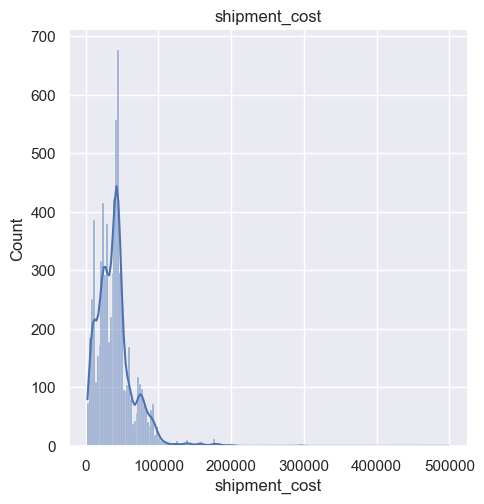

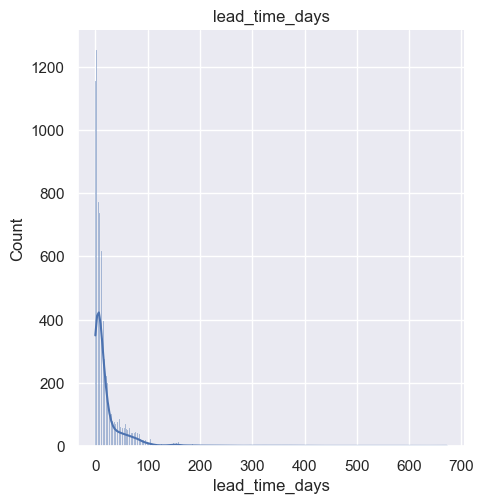

In [24]:
for k in num:
    if k != 'freight_rate':
        sns.displot(num[k],kde= True)
        plt.title(k)
        plt.show()

We can see that **none of the columns** shows a clear normal distribution, the closest we have is shipment cost, but as we concluded before, this column will not matter for us.

If that said, **we'll need to transform the data** to get good results.

##### 3.4 Exploring Outliers 

Now, let's create some dedicated plots to explore this topic.

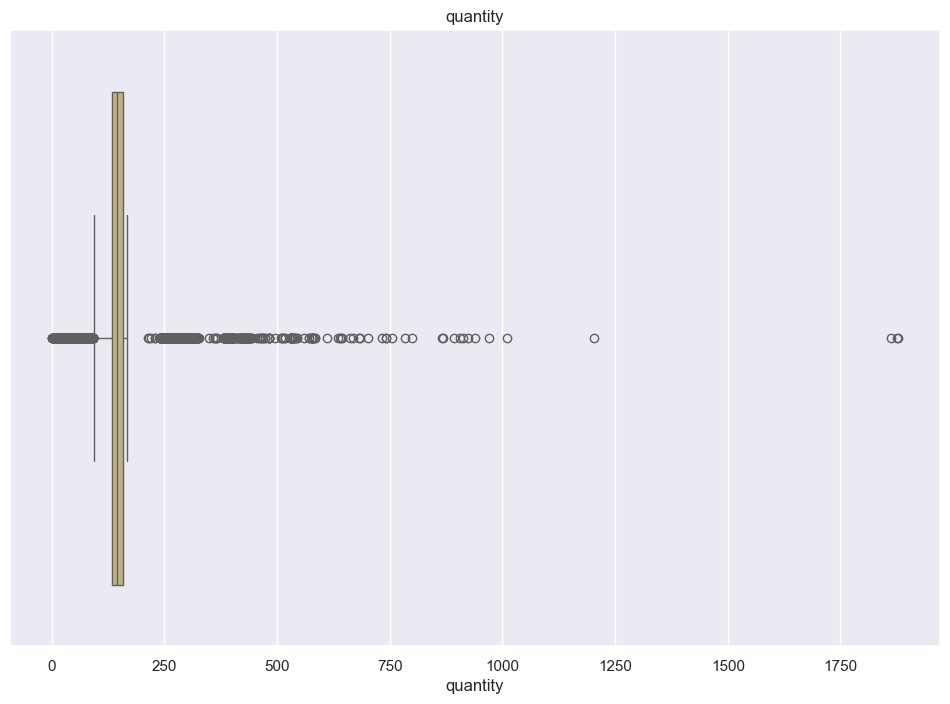

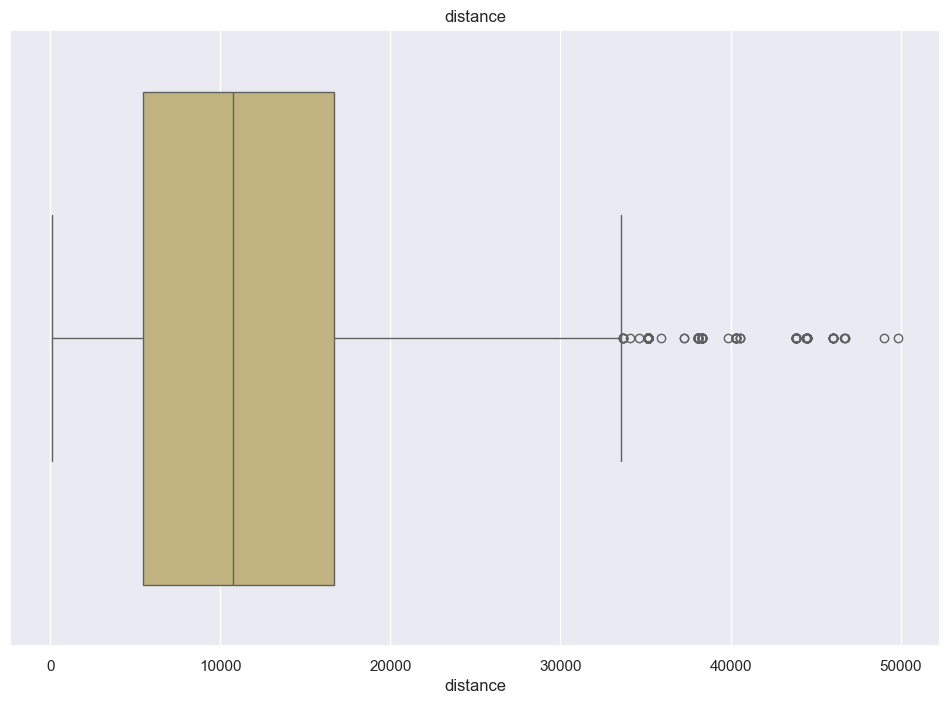

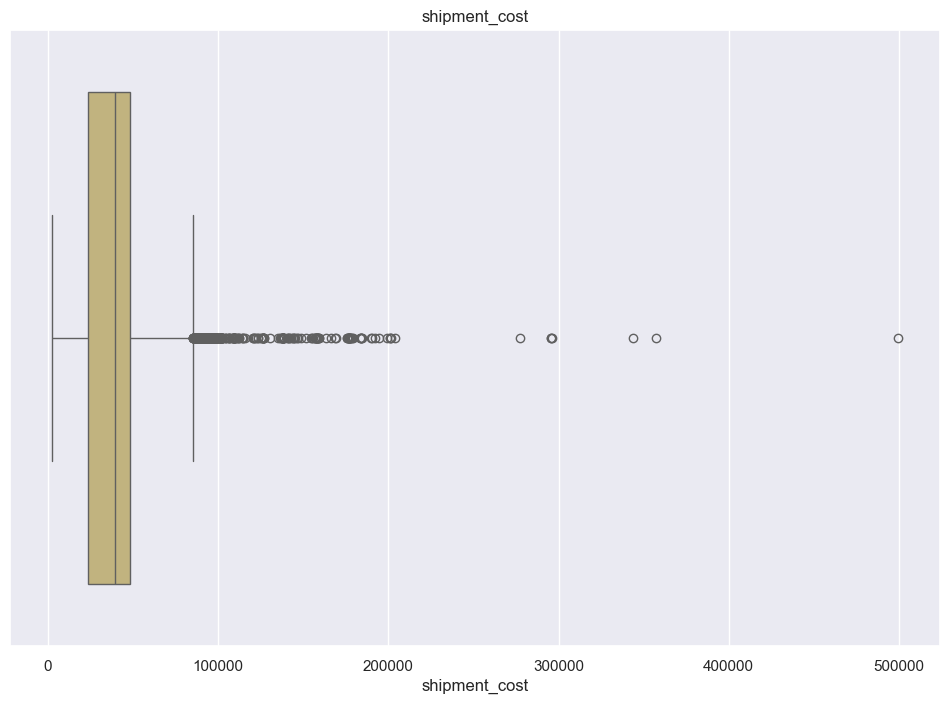

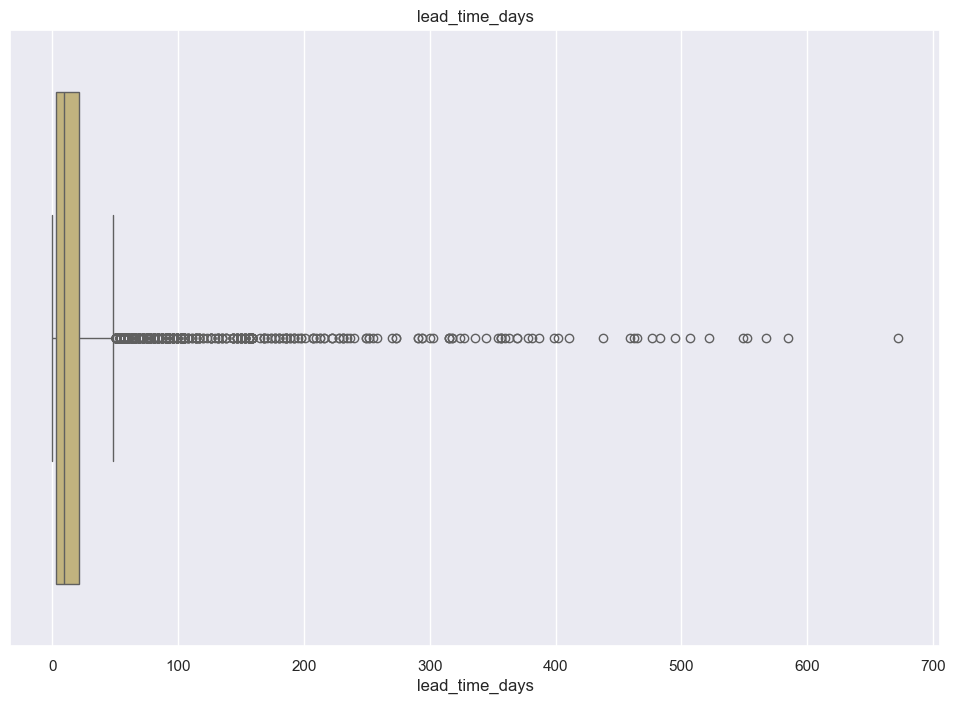

In [25]:
for k in num:
    if k != 'freight_rate':
        sns.boxplot(x=freight_df[k],color = 'y')
        plt.title(k)
        plt.show()

From all the exploratory analysis, we can see that the closest candidate that we got to select as our main variable in the influence of freight rate is ***Distance***.
<br><br>
The main reasons being:
<br>
I) It has few outliers only;
<br>
II) its relation with freight rate it's almost linear, which is way better compare to the other columns (excluding shipment_cost);
<br>
III) with the right transformations, we can make the data have normal distribution.


Next up, we'll use **Feature Engineering** to prove the points mentioned above

#### **4. Feature Engineering**

In this secion, we'll select features from our data and study some parameters about them, like the correlation.


##### 4.1 Feature Selection

First Transforming categorical data into numbers, so the computer can better analyze the parameters and we're going to make a copy of the original dataset, just to be safe.

In [26]:
f_df = freight_df.copy()
for k in cat:
    ordinal = {j:i for i,j in enumerate(f_df[k].unique(),0)}
    f_df[k] = f_df[k].map(ordinal)

Now we're going to take to categorical columns and transform them into a list, so we can create a dataframe just with the transformed categorical columns.
<br>
That way we can create another table called **y** just with the freight rate, in order to compare both of them and calculate the correlation.

In [27]:
cat_cols = cat.columns 
print(cat_cols)
feat_cat = f_df.drop(num.columns,axis=1)


feat_cat = feat_cat.drop(['distance_unit','currency'], axis = 1) ## removing distance_unit and currency, since they don't impact the final results at all
y = f_df['freight_rate'].astype(int)


Index(['transportation_mode', 'segment', 'incoterms_key', 'distance_unit',
       'currency'],
      dtype='object')


##### 4.2 Correlation

Performing chi² test, the higher the score, the higher the correlation

##### *4.2.1 Categorical Var Correlation*

In [28]:
chi = chi2(feat_cat,y)
p_values = pd.Series(chi[1])
p_values.index = feat_cat.columns
cat_corr = p_values
cat_corr_filter = list(
    (cat_corr[(cat_corr!=0)
              &(cat_corr!=1)
              ]
              ).index.values)

print(cat_corr)
print(f'\nFinal Cat List:\n {cat_corr_filter}')


transportation_mode    4.482658e-264
segment                5.001490e-176
incoterms_key           1.000000e+00
dtype: float64

Final Cat List:
 ['transportation_mode', 'segment']


##### *4.2.2 Numerical Var Correlation*

<Axes: >

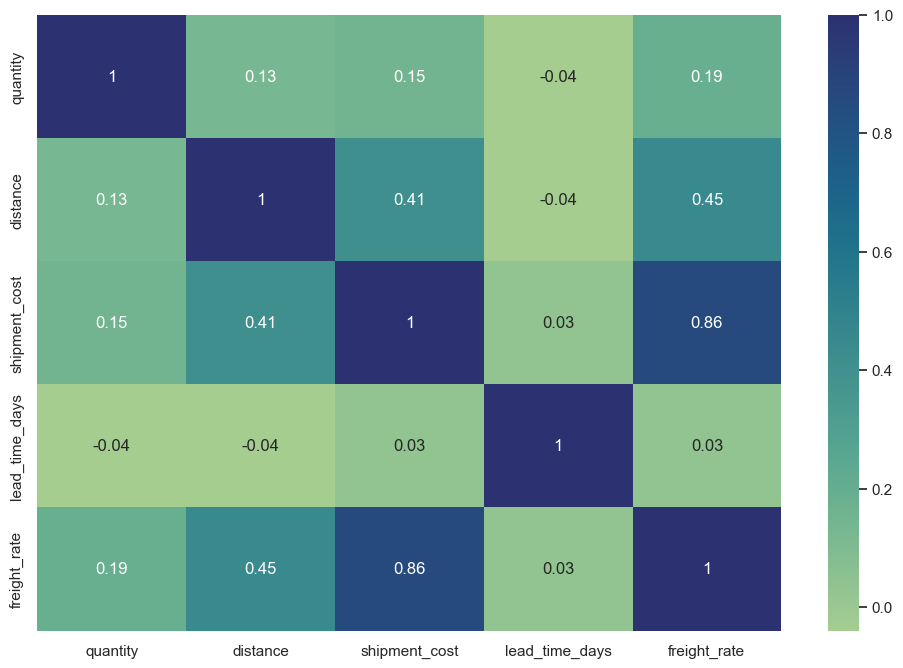

In [29]:
corr_all_cols=num.corr().round(2)
sns.heatmap(data=corr_all_cols, annot = True,cmap="crest")


Auto Selecting the numerical variables based on chi²

Final Numerical list:
['distance', 'freight_rate']


<Axes: >

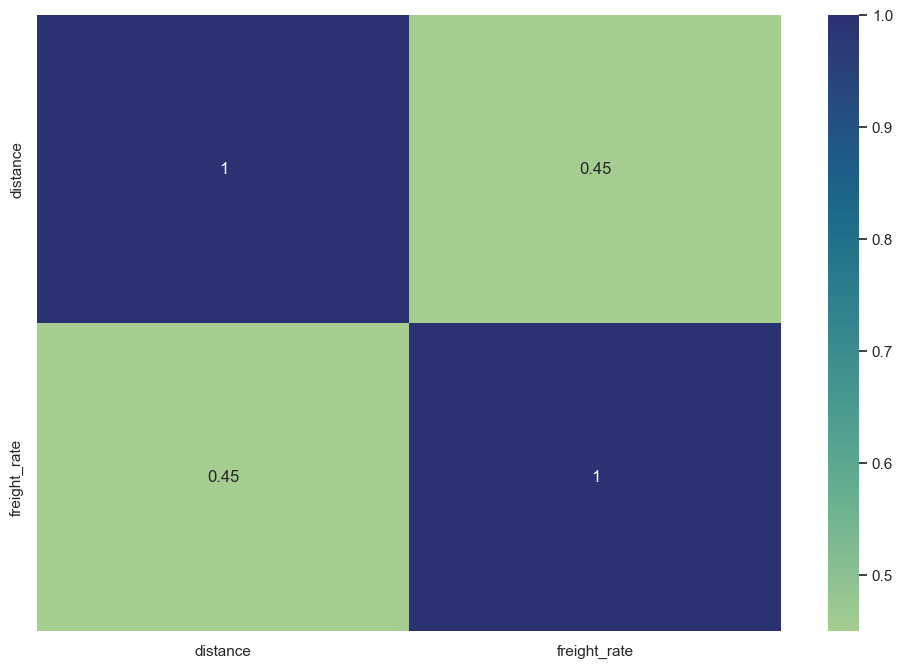

In [30]:
corr_all = corr_all_cols['freight_rate']
corr_all = corr_all[(corr_all!=0) 
                    & (corr_all!=1)
                    & (corr_all>0.3)
                    & (corr_all<0.8)
                    ].dropna()
num_corr_filter = list(corr_all.index.values)
num_corr_filter.append('freight_rate')
print(f'Final Numerical list:\n{num_corr_filter}')

num_new =num_corr_filter

feat_num = f_df[num_new]
num_corr = feat_num.corr().round(2)

## Consider only: distance and net_weight_kg
## The usage of corr near 1 will overfit the model
## Don't use columns that have -0.7<corr>0.7
sns.heatmap(data=num_corr, annot = True,cmap="crest")



Let's plot again the linear relation between the resulting columns from our analysis and freight rate, this will mostly make sense for the only numerical columns left (distance)

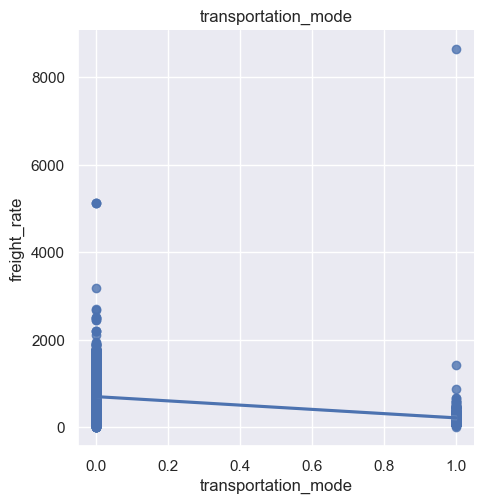

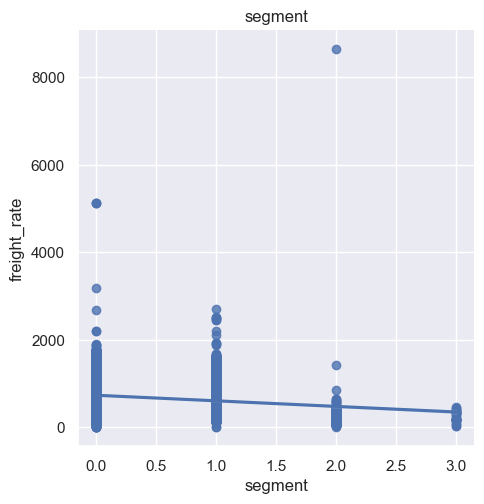

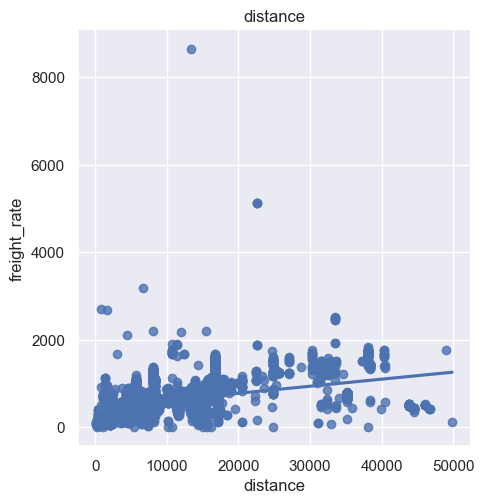

In [38]:
final_cols = cat_corr_filter + num_corr_filter
f_df_filter = f_df[final_cols]
for k in final_cols:
    if k != 'freight_rate': 
        sns.lmplot(x=k,y='freight_rate', data=f_df_filter, order = 1)
        plt.title(k)
        plt.ylabel('freight_rate')
        plt.xlabel(k)
        plt.show()



It seems that we have some outlier our numerical column.
<br>
Let's create a simple function to deal with these outliers

##### 4.3 Simple Outlier Removal

In order the remove the outliers, we going to do a very basic analysis based on the **mean and standard deviation** of the data, and **remove everything that doesn’t fit a certain threshold**, in other words, that stays to far from the bulk of the data.
<br><br>
We can do that using the **zscore method from scipy.stats**


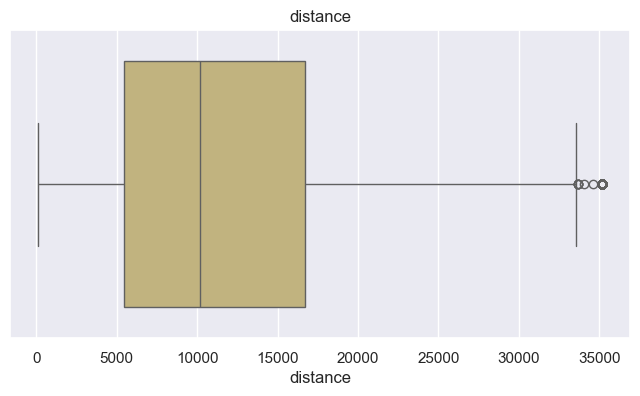

In [43]:
def outlier_removal(df,cols):
    no_outliers = df.copy()
    for k in cols: 
        z = np.abs(scipy.stats.zscore(df[k]))
        outlier_idex = np.where(z>threshold_z)[0] ## Identify the index of outliers
        no_outliers = df.drop(outlier_idex) ## Drop the outliers
        sns.boxplot(x=no_outliers[k], color = 'y')
        plt.title(k)
        plt.show()
        #fig = px.box(no_outliers['freight_rate'],no_outliers[k])  
        #fig.update_layout(title_text = k+' Box Plot')
        #fig.show()
    return no_outliers
threshold_z = 2
outlier_cols = ['distance']
df_filter_no_out= outlier_removal(f_df_filter,outlier_cols)

#### **5.Normalizing test & Transformation**

As we seen before, this data needs to be transformed in order for us to apply any type of regression and effectively predict some results.
<br><br>
For this exercise, we're only testing two transformations:
<br>
i) **Log Transformation**
<br>
ii) **Box-Cox Transformation**
<br><br>
And we're going to make so the user can select between the two while executing the function 


In [53]:
def tranform(df,x,y,transfomation):
    df_t = df.copy()
    if transfomation == 'Log':
        df_t['x_t']=np.log(df_t[x])  
        
    if transfomation == 'Box-Cox':
        df_t['x_t'],best_lambda = scipy.stats.boxcox(df_t[x])
            
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.suptitle(transfomation +' Q-Q Plot - '+x)
    scipy.stats.probplot(df_t[x], dist='norm',plot=ax1)
    scipy.stats.probplot(df_t['x_t'], dist='norm',plot=ax2)
    ax1.set_title('Original')
    ax2.set_title(transfomation)
    plt.show()
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.suptitle('Linear Reg. Model - '+x)

    ax[0].scatter(x=df_t[x],y=df_t[y])
    ax[0].set_title('Original')
    ax[1].scatter(x=df_t['x_t'],y=df_t[y],c='purple')
    ax[1].set_title(transfomation)
    
    df_t = df_t.drop(x,axis=1) 
    return df_t

##### *5.1 Log Transformation* 

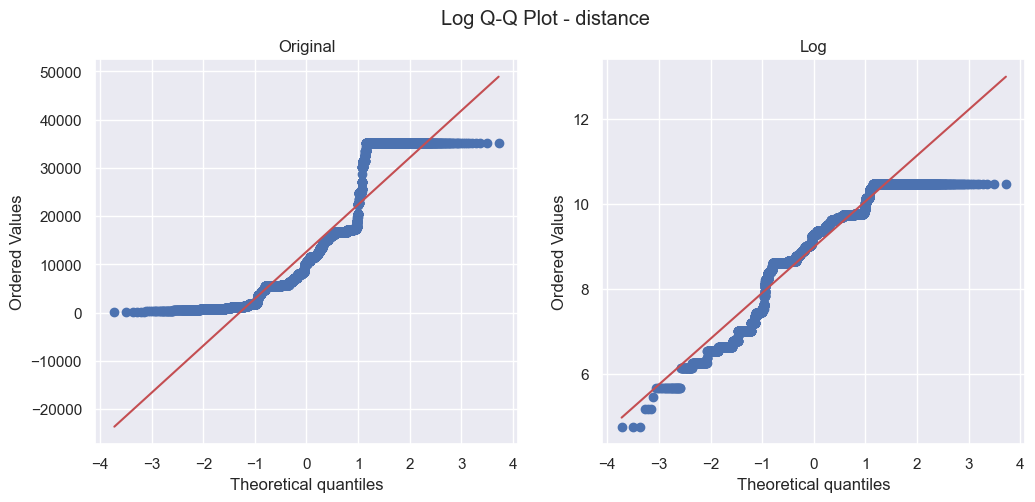

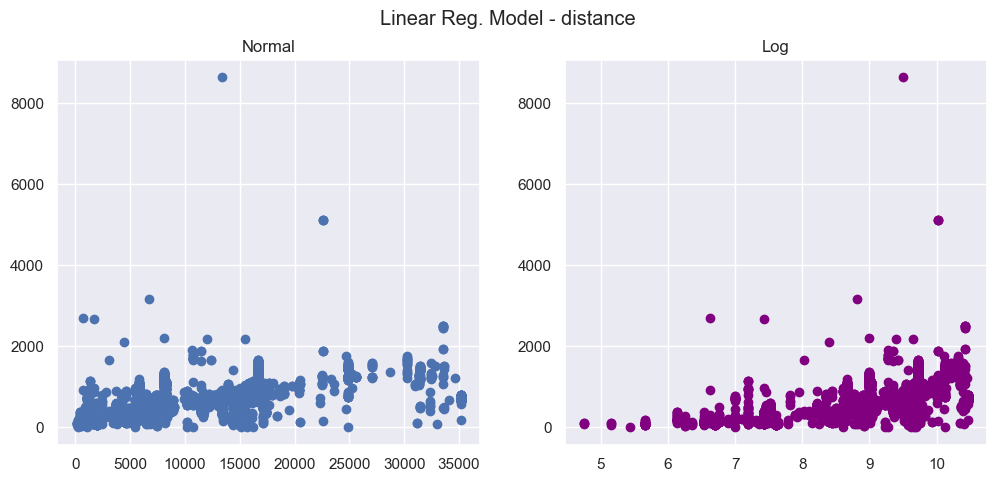

In [52]:
log_t = tranform(df_filter_no_out,'distance','freight_rate','Log')


From the Q-Q Plot we can see that the data is a bit better now, but is not a significant improvement, let's check the Box-Cox Transformation now

##### *5.2 Box-Cox Transformation* 

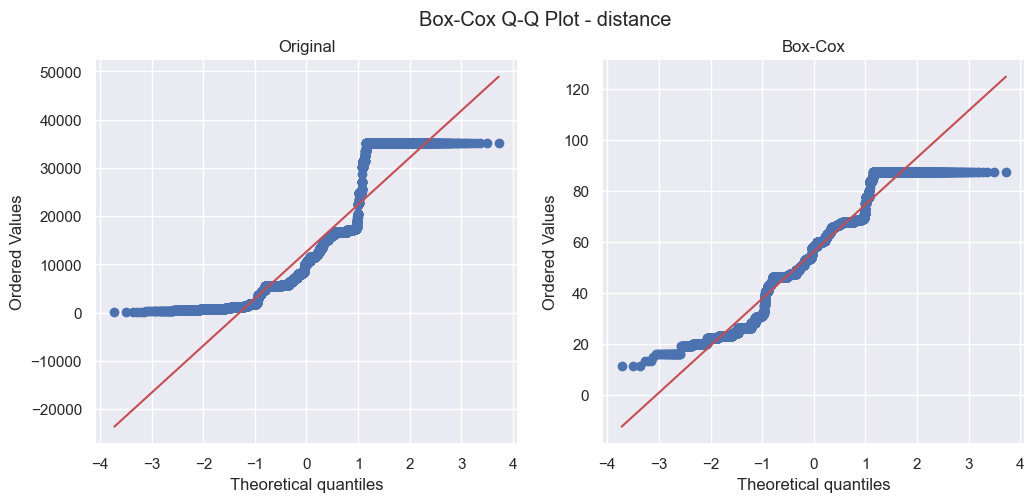

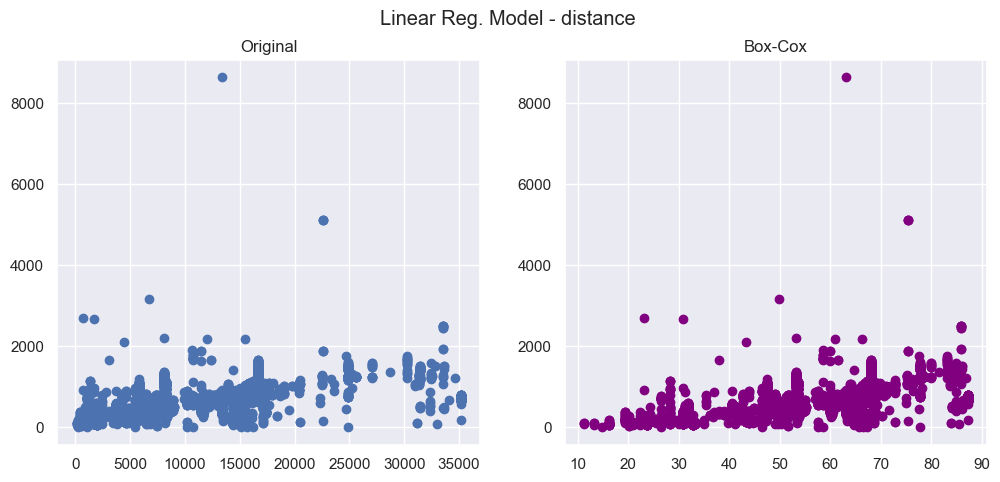

In [54]:
box_t = tranform(df_filter_no_out,'distance','freight_rate','Box-Cox')

Again, this transformation may not be the best, and it's hard to tell just with these graphs if this is better than the Log transformation.
<br>
One thing that we can do to make sure which one is best, is to apply it directly to our regression models, and that's what we're going to do!
<br><br>
But first, we need to build the models

#### **6.Model Building**

After all this data curation and analysis, we can finally start building the model, in this exercise we're going to tackle tree different models for this study:
<br><br>
- Linear Regression;
<br>
- Support Vector Regression;
<br>
- Decision Tree.
<br><br>
And after testing all of them, we can decide which one will best fit our data to predict the freight rate.
<br><br>
*if you want a detailed explanation about each model and how they work, follow me on social media (link's at the end and the README file), I'll be posting a detailed study about these models very soon!*

To make it easier, I'm already going to define all the variables that we're going to use in the models, they'll make sense once we look at the functions.

In [55]:
x_list = df_filter_no_out.drop(['freight_rate'], axis = 1).columns.tolist() ## Removing every column except the one we're trying to predict
y_col = 'freight_rate' ## The columns we're trying to predict
num_col = 'distance' ## Our original numerical column
x_list_t = log_t.drop(['freight_rate'], axis = 1).columns.tolist() ## The list of columns from our transformed dataset
num_col_t = 'x_t' ## Our transformed numerical column
test_size = 0.3 ## Separating 30% of the dataset to test and letting the remaining 70% for training

##### *6.1 Linear Regression*

In [65]:
def linear_reg_model(df,x_list,y_col,test_size,num_col):
        df_log = df.copy()
        x = df_log[x_list]
        y = df_log[y_col]

        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size)

        lr = LinearRegression()
        lr.fit(x_train,y_train)
        pred = lr.predict(x_test)

        mae = mean_absolute_error(y_test,pred)
        mse = mean_squared_error(y_test,pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test,pred)

        print('\n===Linear Regression Model Result===')
        print('\nMean Absolute Error: ',round(mae,2))

        print('\nMean Squared Error: ',round(mse,2))
        print('\nRoot Mean Squared Error: ',round(rmse,2))
        print("\nModel accuracy: ", round(r2,2)*100)

        pred_df = pd.DataFrame(data = pred, columns = ['pred'], 
                                index = x_test.index.copy())
        df_result = pd.merge(df_log, pred_df, #how = 'left',
                        left_index = True, right_index = True)    


        df_result.reset_index()
        error = df_result[y_col] - df_result['pred']
                
        plt.subplot()
        plt.title(k)
        plt.scatter(df_result[num_col],df_result[y_col],label='Actual')
        plt.scatter(df_result[num_col],df_result['pred'],
                        label='Predicted', c='red')
        
        plt.legend()
        plt.ylabel(y_col)
        plt.xlabel(num_col)
        plt.show()
        
        sns.displot(data = df_result, x= error,kind = 'kde')
        plt.xlabel("Error")
    
        return df_result


##### *6.1.1 Linear Reg No Transformation*


===Linear Regression Model Result===

Mean Absolute Error:  242.07

Mean Squared Error:  106795.73

Root Mean Squared Error:  326.8

Model accuracy:  28.000000000000004


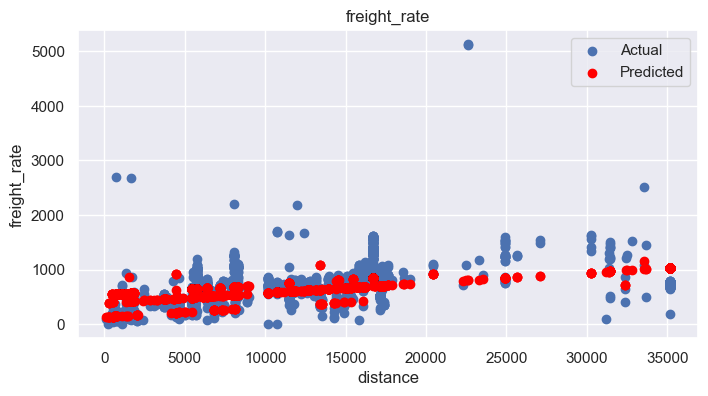

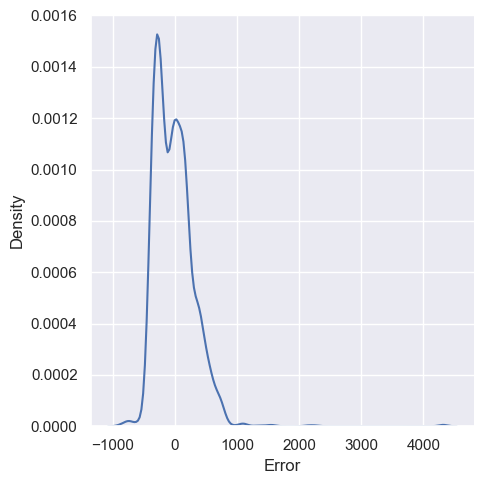

In [67]:
linear_model = linear_reg_model(df_filter_no_out,x_list,y_col,test_size,num_col)

Our first model is done, and we've got an overall accuracy that's not great...
<br>
But let's not lose hope, let's try to apply our model to the transformed datasets

##### *6.1.2 Linear Reg Log Transformation*


===Linear Regression Model Result===

Mean Absolute Error:  213.33

Mean Squared Error:  88588.86

Root Mean Squared Error:  297.64

Model accuracy:  43.0


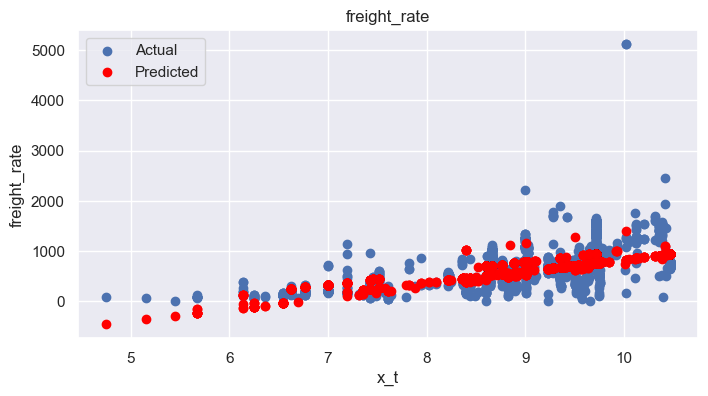

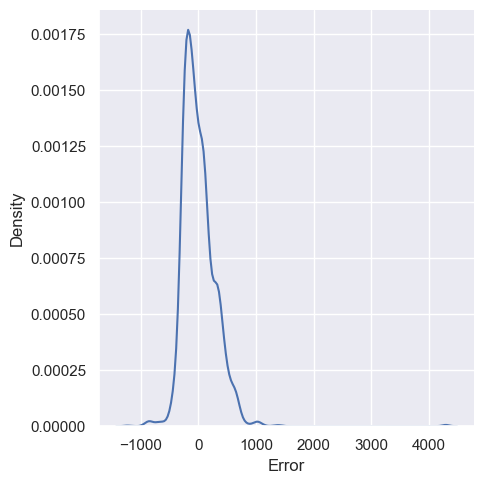

In [68]:
log_linear_model = linear_reg_model(log_t,x_list_t,y_col,test_size,num_col_t)

The results didn't improve that much, so maybe the log transformation wasn't the best option, let's try the Box-Cox.

##### *6.1.3 Linear Reg Box-Cox Transformation*


===Linear Regression Model Result===

Mean Absolute Error:  211.96

Mean Squared Error:  70224.47

Root Mean Squared Error:  265.0

Model accuracy:  47.0


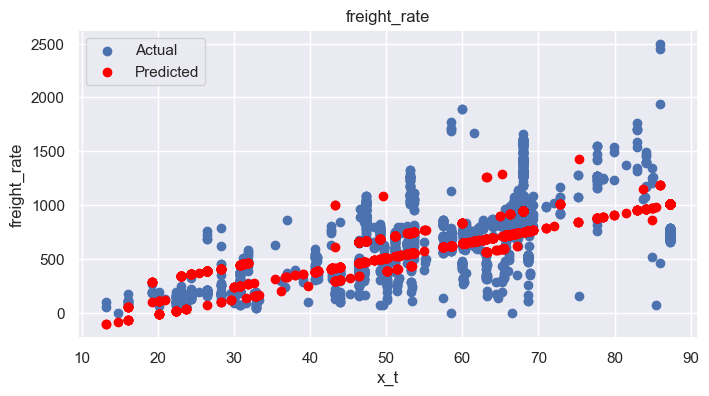

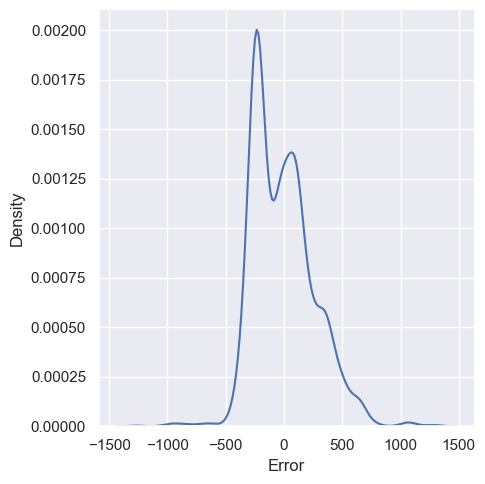

In [69]:
box_linear_model = linear_reg_model(box_t,x_list_t,y_col,test_size,num_col_t)

Now that's better improvement!
<br>
Although the results are still not great, we are on the right track, now we know that Box-Cox transformation is a best fit for our data, compared to the Log transformation.

##### *6.2 Support Vector Regression*


In [75]:
def svr_model(df,x_list,y_col,test_size,num_col):
        df_svr = df.copy()
        x = df_svr[x_list]
        y = df_svr[y_col]

        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size)

        svr_rbf = SVR(kernel='rbf',C=100,gamma=0.1, epsilon=.1)
        svr_rbf.fit(x_train,y_train)
        pred = svr_rbf.predict(x_test)
        mae = mean_absolute_error(y_test,pred)
        mse = mean_squared_error(y_test,pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test,pred)

        print('\n===SVR Model Result===')
        print('\nMean Absolute Error: ',round(mae,2))
        print('\nMean Squared Error: ',round(mse,2))
        print('\nRoot Mean Squared Error: ',round(rmse,2))
        print("\nModel accuracy: ", round(r2,2)*100)



        pred_df = pd.DataFrame(data = pred, columns = ['pred'], index = x_test.index.copy())
        df_result = pd.merge(df_svr, pred_df, #how = 'left',
                        left_index = True, right_index = True)    


        df_result.reset_index()
        error = df_result[y_col] - df_result['pred']

        plt.subplot()
        plt.title(k)
        plt.scatter(df_result[num_col],df_result[y_col],label='Actual')
        plt.scatter(df_result[num_col],df_result['pred'],
                        label='Predicted', c='red')

        plt.legend()
        plt.ylabel(y_col)
        plt.xlabel(num_col)
        plt.show()

        sns.displot(data = df_result, x= error,kind = 'kde')
        plt.xlabel("Error")

        
        return df_result


##### *6.2.1 SVR No Transformation*


===SVR Model Result===

Mean Absolute Error:  80.37

Mean Squared Error:  70182.35

Root Mean Squared Error:  264.92

Model accuracy:  61.0


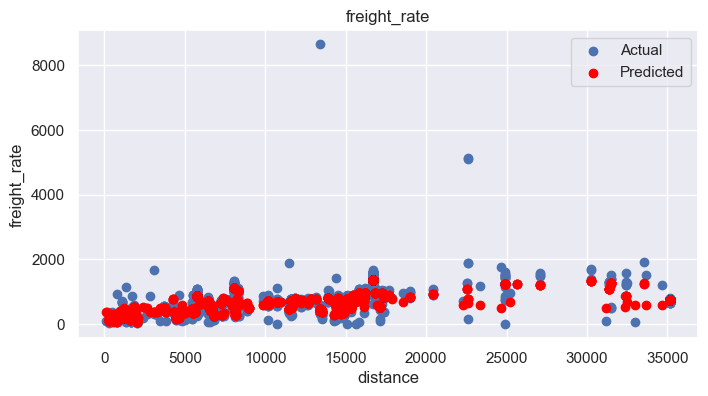

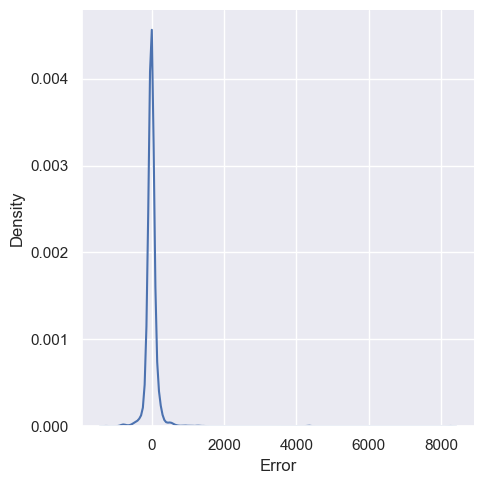

In [72]:
svr_model = svr_model(df_filter_no_out,x_list,y_col,test_size,num_col)

Now we're getting somewhere!
<br>
It's already a good result compare the Linear regression model, now let's try with our transformed data.

##### *6.2.2 SVR Log Transformation*


===SVR Model Result===

Mean Absolute Error:  148.78

Mean Squared Error:  57208.62

Root Mean Squared Error:  239.18

Model accuracy:  60.0


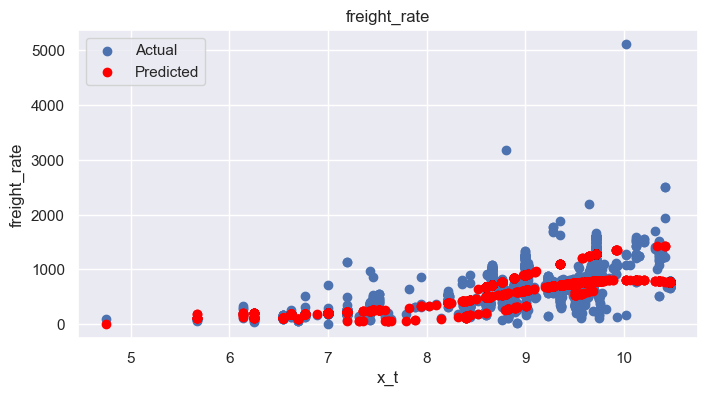

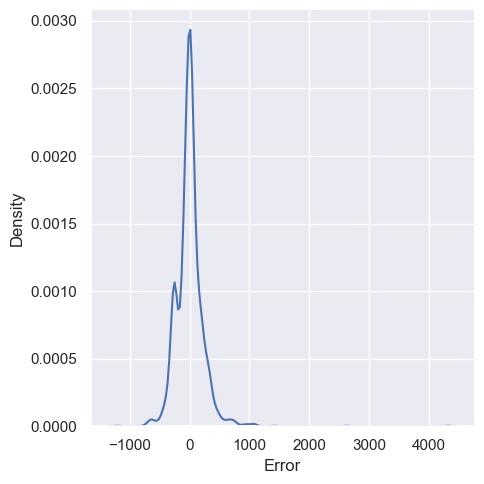

In [76]:
log_svr_model = svr_model(log_t,x_list_t,y_col,test_size,num_col_t)

A good improvement using the Log transformation, now let's try the Box-Cox.

##### *6.2.3 SVR Box-Cox Transformation*


===SVR Model Result===

Mean Absolute Error:  103.3

Mean Squared Error:  45721.39

Root Mean Squared Error:  213.83

Model accuracy:  70.0


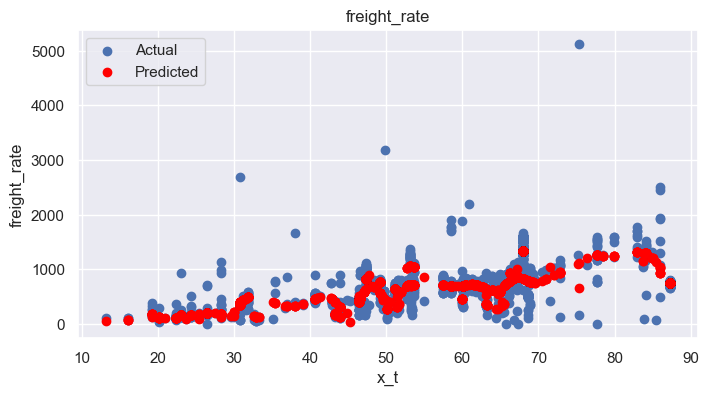

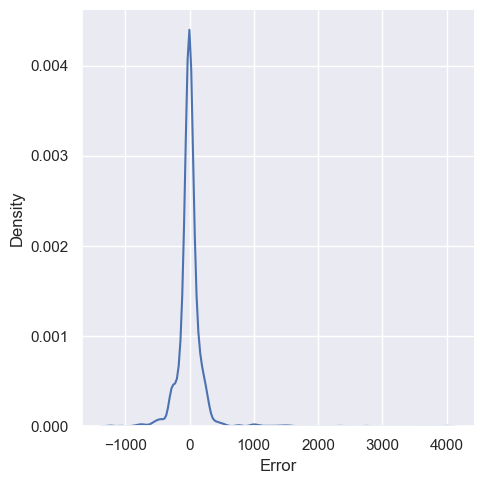

In [77]:
box_svr_model = svr_model(box_t,x_list_t,y_col,test_size,num_col_t)

Our initial thought was correct, just like in the Linear Regression Model, the Box-Cox Transformation performed in our data, helping us break a new accuracy threshold.
<br><br>

That being said, let's jump to our last model.


##### *6.3 Decision Tree*


Decision Tree is a very powerful regressor, that allow us to predict nonlinear data, due to the fact of the number of parameters that we can chose for out model.
<br>
And choosing the right parameters it's a crucial step in order to use the full power of this model, that's why we're going to do create a function that basically do a grid search for the best parameters for our decision tree.

##### *6.3.1 Hyper Parameter Tuning Decision Tree*

In [78]:
def param_tuning_dt(df,x_list,y_col,test_size):
    df_tree = df.copy()
    x = df_tree[x_list]
    y = df_tree[y_col]
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size
                                                     #,random_state=42
                                                     )
  
    tree_reg = tree.DecisionTreeRegressor()#random_state=42)
    tree_reg.fit(x_train,y_train)
   
    param_dict = {
            
              #'criterion': ['squared_error', 'friedman_mse', 'absolute_error','poisson'], ## Slows down the performance and the results are not impacted by a large margin
              'max_depth': [1,2,4,6,8,10], 
              'max_features': [0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7], 
              'min_samples_split': [2,3,4,5,6,7,8]
              }
    grid_cv = GridSearchCV(tree_reg, param_grid=param_dict, cv=10,n_jobs=-1)
    print('\n===Hyper Parameter Tuning===')
    print('\n',grid_cv.fit(x_train,list(map(int,y_train))))
    print('\n',grid_cv.best_estimator_)
    print('\n',grid_cv.best_score_)
    print('\n',grid_cv.best_params_)
    print('\n==========================\n')
        
    return list(grid_cv.best_params_.values())


Now we can **call this function inside our model building function** in order to find the best parameters for any given dataset, it might take longer to execute, but it's worth it!
<br><br>
You may have notice that all the **random states lines are commented**, that's because I want the model to run at "random" (like the cool data kids do) for demonstration purpose. It's possible to uncomment the lines and set the random state as 42, so the model "stores" it's decision regardless of how many times you execute.

##### *6.3.2 Decision Tree Model Building*

In [79]:
def decision_tree(df,x_list,y_col,test_size,num_col):
        params = param_tuning_dt(df,x_list,y_col,test_size)
        df_tree = df.copy()
        x = df_tree[x_list]
        y = df_tree[y_col]

        x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size
                                                        #,random_state=42 
                                                        )

        tree_reg = tree.DecisionTreeRegressor(
                                                max_depth = params[0]
                                                ,max_features = params[1]
                                                ,min_samples_split = params[2]
                                                #,random_state=42
                                                )                                  
                                                

        tree_reg.fit(x_train,y_train)
        #tree.plot_tree(tree_reg) ## This will plot the decision tree map, but takes a lot of memory to execute

        pred = tree_reg.predict(x_test) 
        mae = mean_absolute_error(y_test,pred)
        mse = mean_squared_error(y_test,pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test,pred)

        print('\n===Decision Tree Model Result===')
        print('\nMean Absolute Error: ',round(mae,2))
        print('\nMean Squared Error: ',round(mse,2))
        print('\nRoot Mean Squared Error: ',round(rmse,2))
        print("\nModel accuracy: ", round(r2,2)*100)
        print('\n==============================\n')


        pred_df = pd.DataFrame(data = pred, columns = ['pred'], 
                                index = x_test.index.copy())
        df_result = pd.merge(df_tree, pred_df,
                        left_index = True, right_index = True)    


        df_result.reset_index()
        error = df_result[y_col] - df_result['pred']


        plt.subplot()
        plt.title(k)
        plt.scatter(df_result[num_col],df_result[y_col],label='Actual')
        plt.scatter(df_result[num_col],df_result['pred'],
                        label='Predicted', c='red')

        plt.legend()
        plt.ylabel(y_col)
        plt.xlabel(num_col)
        plt.show()

        sns.displot(data = df_result, x= error,kind = 'kde')
        plt.xlabel("Error")

        return df_result


##### *6.2.3 Decision Tree No Transformation*


===Hyper Parameter Tuning===

 GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8]})

 DecisionTreeRegressor(max_depth=10, max_features=0.1, min_samples_split=7)

 0.7720839308939507

 {'max_depth': 10, 'max_features': 0.1, 'min_samples_split': 7}



===Decision Tree Model Result===

Mean Absolute Error:  82.4

Mean Squared Error:  57519.54

Root Mean Squared Error:  239.83

Model accuracy:  68.0




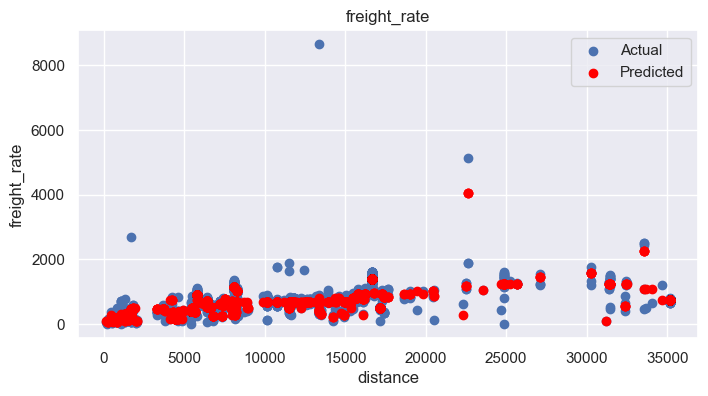

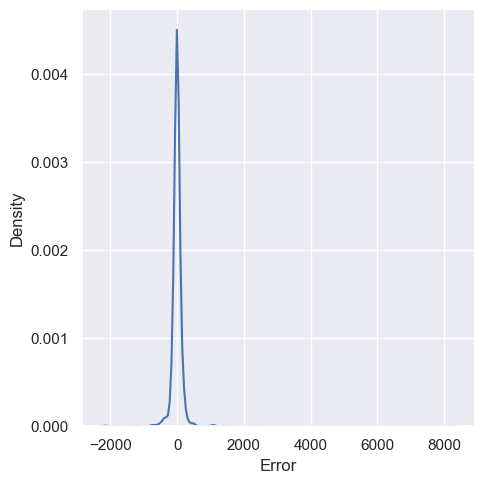

In [80]:
decision_tree_model = decision_tree(df_filter_no_out,x_list,y_col,test_size,num_col)

Without any transformation, we can see that the decision tree **achieved the best results** compared to the other models, that's to show the power of this regression!
<br><br>
Now, let's test it with the transformed data.

##### *6.2.3 Decision Tree Log Transformation*


===Hyper Parameter Tuning===

 GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8]})

 DecisionTreeRegressor(max_depth=10, max_features=0.4, min_samples_split=3)

 0.7810868475817032

 {'max_depth': 10, 'max_features': 0.4, 'min_samples_split': 3}



===Decision Tree Model Result===

Mean Absolute Error:  83.24

Mean Squared Error:  32242.34

Root Mean Squared Error:  179.56

Model accuracy:  78.0




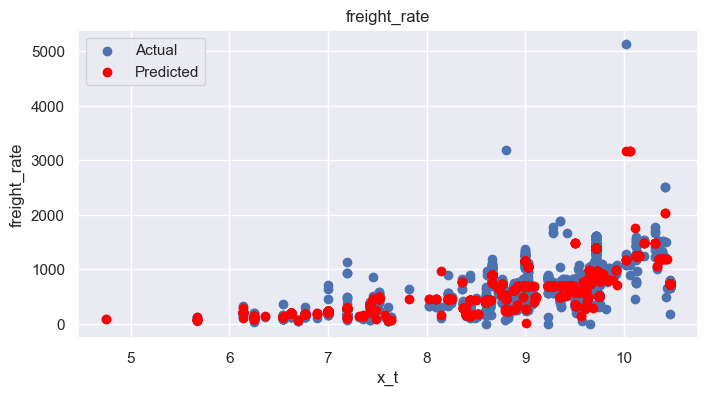

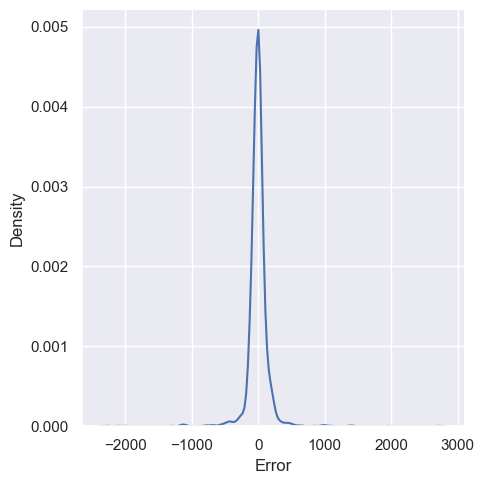

In [82]:
log_decision_tree_model = decision_tree(log_t,x_list_t,y_col,test_size,num_col_t)

##### *6.2.4 Decision Tree Box-Cox Transformation*


===Hyper Parameter Tuning===

 GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8]})

 DecisionTreeRegressor(max_depth=10, max_features=0.7, min_samples_split=5)

 0.8104328257538992

 {'max_depth': 10, 'max_features': 0.7, 'min_samples_split': 5}



===Decision Tree Model Result===

Mean Absolute Error:  82.06

Mean Squared Error:  28733.51

Root Mean Squared Error:  169.51

Model accuracy:  81.0




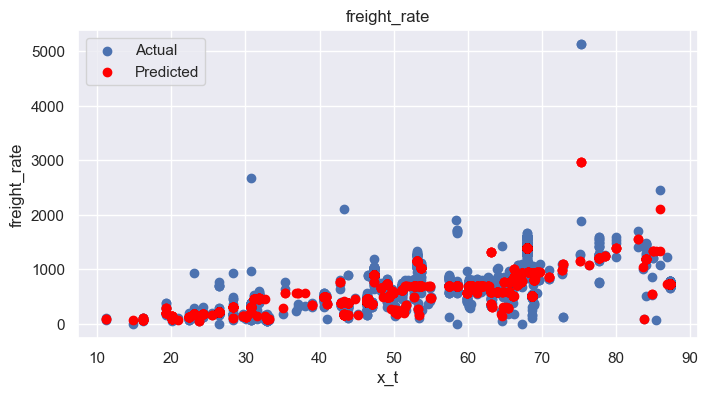

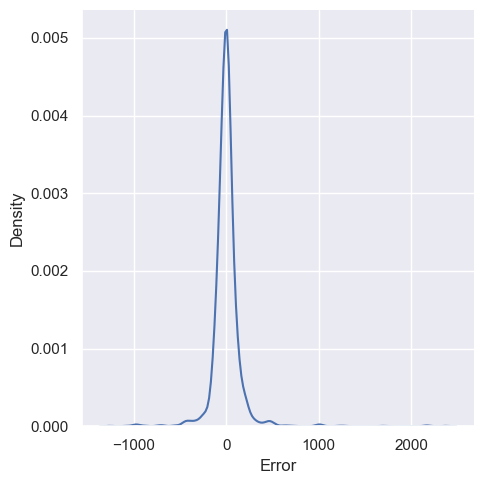

In [86]:
box_decision_tree_model = decision_tree(box_t,x_list_t,y_col,test_size,num_col_t)

And just like that, we managed to build a good model for predicting the freight rate based on the distance for the numerical column, transportation mode and segment for the categorical columns.
<br><br>
If we have this information, we can use them to plan our next transportation routes and better optimize the costs!

#### **7. Conclusion**

After analyzing the data, we were able to determine which transformation to use and could build our models, and it's important to test all the possible models.
<br><br>
That goes to show that, when dealing with data analysis and Machine Learning model building, ***we should never jump to conclusions before testing every hypothesis***. 
<br><br>
Ate the end, we managed to understand our data just with some simple analysis and build a good model with an optimal accuracy given the methods used.
<br><br>
Now, the next steps would be to use this model into an unseen data, to actually give us some projections, based on the chosen parameters and then, we would need to transform the categorical values back to its original text form. But that would be a task for our next project. 
<br><br>
The best part is that this analysis is fully customizable and can offer way more insight, and that's the beauty of Data Analytics!
<br><br><br>
*Hope you liked the analysis, feel free to check out my LinkedIn and my GitHub.*

